In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import ParameterSampler
import torch.nn.functional as F
from torchvision import transforms

# Parameters
IMG_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 19
NUM_EPOCHS = 5

METAINFO = {
    "classes": (
        "unlabelled", "asphalt/concrete", "dirt", "mud", "water", "gravel",
        "other-terrain", "tree-trunk", "tree-foliage", "bush/shrub", "fence",
        "other-structure", "pole", "vehicle", "rock", "log", "other-object",
        "sky", "grass",
    ),
    "palette": [
        (0, 0, 0), (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200),
        (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60),
        (250, 190, 190), (0, 128, 128), (170, 110, 40), (255, 250, 200),
        (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180),
        (0, 0, 128), (128, 128, 128),
    ],
    "cidx": list(range(19))
}

In [2]:
class CombinedSegmentationLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, boundary_weight=1.0, dice_weight=1.0):
        super(CombinedSegmentationLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.boundary_weight = boundary_weight
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        # Multi-class Cross Entropy Loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Varifocal Loss component
        pred_prob = F.softmax(inputs, dim=1)
        pt = pred_prob.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_weight = self.alpha * (1 - pt).pow(self.gamma)
        vfl_loss = focal_weight * ce_loss

        # Dice Loss component
        smooth = 1e-6
        inputs_softmax = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (inputs_softmax * targets_one_hot).sum(dim=(2, 3))
        dice_loss = 1 - (2 * intersection + smooth) / (inputs_softmax.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3)) + smooth)

        # Combine losses
        combined_loss = vfl_loss.mean() + self.dice_weight * dice_loss.mean()

        return combined_loss


In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, deep_supervision=True, dropout_prob=0.1):
        super(UNetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = ConvBlock(3, nb_filter[0], dropout_prob)
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1], dropout_prob)
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2], dropout_prob)
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3], dropout_prob)
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4], dropout_prob)

        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1], dropout_prob)
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2], dropout_prob)
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3], dropout_prob)

        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], dropout_prob)
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], dropout_prob)

        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], dropout_prob)

        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], dropout_prob)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            return output

In [4]:
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

train_df = load_and_sample_data('/kaggle/input/train-sample-30/train_final.csv', sample_fraction=1/3)
val_df = load_and_sample_data('/kaggle/input/train-sample-30/val_final.csv')
test_df = load_and_sample_data('/kaggle/input/wildscenes2d/test.csv')

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

class WildScene(Dataset):
    def __init__(self, df, img_size, num_classes, is_train=False):
        self.df = df
        self.img_size = img_size
        self.num_classes = num_classes
        self.is_train = is_train

        # Training transforms with data augmentation
        self.train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
        ])

        # Evaluation transforms without data augmentation
        self.eval_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread('/kaggle/input/wildscenes2d/WildScenes2d/' + row['im_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread('/kaggle/input/wildscenes2d/WildScenes2d/' + row['label_path'], cv2.IMREAD_GRAYSCALE)

        if self.is_train:
            # Apply training transforms
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            img = self.train_transform(img)
            
            torch.manual_seed(seed)
            label = transforms.functional.to_tensor(
                transforms.functional.resize(
                    transforms.ToPILImage()(label), 
                    (self.img_size, self.img_size)
                )
            )
        else:
            # Apply evaluation transforms
            img = self.eval_transform(img)
            label = transforms.functional.to_tensor(
                transforms.functional.resize(
                    transforms.ToPILImage()(label), 
                    (self.img_size, self.img_size)
                )
            )

        label = label.squeeze().long()

        return img, label

In [5]:
# Create datasets with appropriate transforms
train_dataset = WildScene(train_df, IMG_SIZE, NUM_CLASSES, is_train=True)
val_dataset = WildScene(val_df, IMG_SIZE, NUM_CLASSES, is_train=False)
test_dataset = WildScene(test_df, IMG_SIZE, NUM_CLASSES, is_train=False)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, early_stop_epochs=3):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                if isinstance(outputs, list):
                    loss = sum([criterion(output, labels) for output in outputs]) / len(outputs)
                else:
                    loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, labels = images.cuda(), labels.cuda()
                with autocast():
                    outputs = model(images)
                    if isinstance(outputs, list):
                        loss = sum([criterion(output, labels) for output in outputs]) / len(outputs)
                    else:
                        loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Early stopping check
        if epoch >= early_stop_epochs and val_losses[-early_stop_epochs] < val_loss:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print("Training complete.")
    return model, train_losses, val_losses

In [7]:
def random_search(param_distributions, n_iter=10, initial_epochs=3, full_epochs=10):
    param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))
    
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    
    for i, params in enumerate(param_list):
        print(f"\nTrying combination {i+1}/{len(param_list)}:")
        print(params)

        model = UNetPlusPlus(num_classes=NUM_CLASSES, deep_supervision=True, dropout_prob=params['dropout_prob']).cuda()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = CombinedSegmentationLoss(alpha=params['focal_alpha'], gamma=params['focal_gamma'], boundary_weight=params['boundary_weight'], dice_weight=params['dice_weight'])
        
        try:
            # Initial evaluation phase
            trained_model, _, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=initial_epochs)
            
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                best_model = trained_model
                best_params = params
                print(f"New best model found with initial validation loss: {best_val_loss}")

                # Full evaluation phase
                trained_model, _, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=full_epochs)
                if val_losses[-1] < best_val_loss:
                    best_val_loss = val_losses[-1]
                    best_model = trained_model
                    best_params = params
                    print(f"New best model found with full validation loss: {best_val_loss}")
        except RuntimeError as e:
            print(f"Error during training: {str(e)}")
            continue
    
    return best_model, best_params

In [8]:
param_distributions = {
    'dropout_prob': [0.1, 0.2, 0.3],
    'learning_rate': [5e-4, 1e-3],
    'focal_alpha': [0.25, 0.5, 0.75],
    'focal_gamma': [1, 2, 3],
    'boundary_weight': [0.5, 1.0, 1.5],
    'dice_weight': [0.5, 1, 1.5]
}
best_model, best_params = random_search(param_distributions, n_iter=20, initial_epochs=3, full_epochs=10)
print("Best parameters:", best_params)

# Train the final model with the best parameters
final_model = UNetPlusPlus(num_classes=NUM_CLASSES, deep_supervision=True, dropout_prob=best_params['dropout_prob']).cuda()
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
final_criterion = CombinedSegmentationLoss(alpha=best_params['focal_alpha'], gamma=best_params['focal_gamma'], boundary_weight=best_params['boundary_weight'], dice_weight=best_params['dice_weight'])

trained_model, train_losses, val_losses = train_model(final_model, train_loader, val_loader, final_optimizer, final_criterion, num_epochs=NUM_EPOCHS)



Trying combination 1/20:
{'learning_rate': 0.0005, 'focal_gamma': 1, 'focal_alpha': 0.75, 'dropout_prob': 0.2, 'dice_weight': 1, 'boundary_weight': 0.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [02:04<00:00,  1.92s/it]


Epoch 1/3, Train Loss: 2.4426, Val Loss: 2.0929


Validation Epoch 2/3: 100%|██████████| 65/65 [01:29<00:00,  1.37s/it]


Epoch 2/3, Train Loss: 1.6883, Val Loss: 1.4044


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 1.2560, Val Loss: 1.1054
Training complete.
New best model found with initial validation loss: 1.1053705804596536


Validation Epoch 1/10: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 1/10, Train Loss: 1.0748, Val Loss: 1.0143


Validation Epoch 2/10: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 2/10, Train Loss: 1.0133, Val Loss: 0.9795


Validation Epoch 3/10: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/10, Train Loss: 0.9874, Val Loss: 0.9644


Validation Epoch 4/10: 100%|██████████| 65/65 [01:27<00:00,  1.35s/it]


Epoch 4/10, Train Loss: 0.9741, Val Loss: 0.9581


Validation Epoch 5/10: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 5/10, Train Loss: 0.9667, Val Loss: 0.9547


Validation Epoch 6/10: 100%|██████████| 65/65 [01:31<00:00,  1.40s/it]


Epoch 6/10, Train Loss: 0.9621, Val Loss: 0.9527


Validation Epoch 7/10: 100%|██████████| 65/65 [01:30<00:00,  1.40s/it]


Epoch 7/10, Train Loss: 0.9590, Val Loss: 0.9515


Validation Epoch 8/10: 100%|██████████| 65/65 [01:32<00:00,  1.42s/it]


Epoch 8/10, Train Loss: 0.9568, Val Loss: 0.9506


Validation Epoch 9/10: 100%|██████████| 65/65 [01:32<00:00,  1.43s/it]


Epoch 9/10, Train Loss: 0.9552, Val Loss: 0.9500


Validation Epoch 10/10: 100%|██████████| 65/65 [01:31<00:00,  1.41s/it]


Epoch 10/10, Train Loss: 0.9540, Val Loss: 0.9495
Training complete.
New best model found with full validation loss: 0.9495297727897821

Trying combination 2/20:
{'learning_rate': 0.001, 'focal_gamma': 2, 'focal_alpha': 0.75, 'dropout_prob': 0.2, 'dice_weight': 1.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 1/3, Train Loss: 2.3879, Val Loss: 1.7068


Validation Epoch 2/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 2/3, Train Loss: 1.5983, Val Loss: 1.4657


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 1.4668, Val Loss: 1.4365
Training complete.

Trying combination 3/20:
{'learning_rate': 0.001, 'focal_gamma': 2, 'focal_alpha': 0.25, 'dropout_prob': 0.3, 'dice_weight': 1, 'boundary_weight': 1.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:30<00:00,  1.40s/it]


Epoch 1/3, Train Loss: 1.3627, Val Loss: 1.0598


Validation Epoch 2/3: 100%|██████████| 65/65 [01:31<00:00,  1.41s/it]


Epoch 2/3, Train Loss: 1.0484, Val Loss: 0.9652


Validation Epoch 3/3: 100%|██████████| 65/65 [01:31<00:00,  1.41s/it]


Epoch 3/3, Train Loss: 0.9748, Val Loss: 0.9533
Training complete.

Trying combination 4/20:
{'learning_rate': 0.0005, 'focal_gamma': 1, 'focal_alpha': 0.5, 'dropout_prob': 0.1, 'dice_weight': 1.5, 'boundary_weight': 1.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:29<00:00,  1.37s/it]


Epoch 1/3, Train Loss: 2.4461, Val Loss: 2.1497


Validation Epoch 2/3: 100%|██████████| 65/65 [01:27<00:00,  1.35s/it]


Epoch 2/3, Train Loss: 1.9388, Val Loss: 1.7445


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.37s/it]


Epoch 3/3, Train Loss: 1.6289, Val Loss: 1.5409
Training complete.

Trying combination 5/20:
{'learning_rate': 0.0005, 'focal_gamma': 1, 'focal_alpha': 0.75, 'dropout_prob': 0.1, 'dice_weight': 1.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 1/3, Train Loss: 2.9129, Val Loss: 2.4689


Validation Epoch 2/3: 100%|██████████| 65/65 [01:30<00:00,  1.40s/it]


Epoch 2/3, Train Loss: 2.1401, Val Loss: 1.8523


Validation Epoch 3/3: 100%|██████████| 65/65 [01:33<00:00,  1.43s/it]


Epoch 3/3, Train Loss: 1.6902, Val Loss: 1.5657
Training complete.

Trying combination 6/20:
{'learning_rate': 0.001, 'focal_gamma': 1, 'focal_alpha': 0.5, 'dropout_prob': 0.1, 'dice_weight': 0.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:33<00:00,  1.44s/it]


Epoch 1/3, Train Loss: 1.1814, Val Loss: 0.7570


Validation Epoch 2/3: 100%|██████████| 65/65 [01:33<00:00,  1.43s/it]


Epoch 2/3, Train Loss: 0.5877, Val Loss: 0.5113


Validation Epoch 3/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 3/3, Train Loss: 0.4994, Val Loss: 0.4854
Training complete.
New best model found with initial validation loss: 0.48539008643176107


Validation Epoch 1/10: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 1/10, Train Loss: 0.4853, Val Loss: 0.4795


Validation Epoch 2/10: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 2/10, Train Loss: 0.4806, Val Loss: 0.4772


Validation Epoch 3/10: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 3/10, Train Loss: 0.4784, Val Loss: 0.4761


Validation Epoch 4/10: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 4/10, Train Loss: 0.4771, Val Loss: 0.4754


Validation Epoch 5/10: 100%|██████████| 65/65 [01:27<00:00,  1.35s/it]


Epoch 5/10, Train Loss: 0.4763, Val Loss: 0.4750


Validation Epoch 6/10: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 6/10, Train Loss: 0.4758, Val Loss: 0.4747


Validation Epoch 7/10: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 7/10, Train Loss: 0.4754, Val Loss: 0.4745


Validation Epoch 8/10: 100%|██████████| 65/65 [01:29<00:00,  1.37s/it]


Epoch 8/10, Train Loss: 0.4751, Val Loss: 0.4744


Validation Epoch 9/10: 100%|██████████| 65/65 [01:29<00:00,  1.37s/it]


Epoch 9/10, Train Loss: 0.4749, Val Loss: 0.4743


Validation Epoch 10/10: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 10/10, Train Loss: 0.4748, Val Loss: 0.4742
Training complete.
New best model found with full validation loss: 0.47420341259724386

Trying combination 7/20:
{'learning_rate': 0.001, 'focal_gamma': 3, 'focal_alpha': 0.5, 'dropout_prob': 0.1, 'dice_weight': 1, 'boundary_weight': 0.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 1/3, Train Loss: 1.4837, Val Loss: 1.0816


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 2/3, Train Loss: 1.0038, Val Loss: 0.9679


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 0.9640, Val Loss: 0.9568
Training complete.

Trying combination 8/20:
{'learning_rate': 0.0005, 'focal_gamma': 1, 'focal_alpha': 0.25, 'dropout_prob': 0.1, 'dice_weight': 1.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 1/3, Train Loss: 1.8989, Val Loss: 1.7332


Validation Epoch 2/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 2/3, Train Loss: 1.6300, Val Loss: 1.5313


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 1.4954, Val Loss: 1.4638
Training complete.

Trying combination 9/20:
{'learning_rate': 0.0005, 'focal_gamma': 3, 'focal_alpha': 0.5, 'dropout_prob': 0.1, 'dice_weight': 0.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 1/3, Train Loss: 1.1932, Val Loss: 0.8839


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 2/3, Train Loss: 0.7327, Val Loss: 0.6623


Validation Epoch 3/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 3/3, Train Loss: 0.5549, Val Loss: 0.5175
Training complete.

Trying combination 10/20:
{'learning_rate': 0.0005, 'focal_gamma': 2, 'focal_alpha': 0.75, 'dropout_prob': 0.2, 'dice_weight': 1, 'boundary_weight': 0.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 1/3, Train Loss: 2.2973, Val Loss: 1.9210


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 2/3, Train Loss: 1.6276, Val Loss: 1.3154


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 1.2542, Val Loss: 1.0855
Training complete.

Trying combination 11/20:
{'learning_rate': 0.0005, 'focal_gamma': 2, 'focal_alpha': 0.5, 'dropout_prob': 0.1, 'dice_weight': 1.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:30<00:00,  1.40s/it]


Epoch 1/3, Train Loss: 2.4272, Val Loss: 2.0894


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 2/3, Train Loss: 1.9210, Val Loss: 1.7035


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 1.6181, Val Loss: 1.5194
Training complete.

Trying combination 12/20:
{'learning_rate': 0.0005, 'focal_gamma': 1, 'focal_alpha': 0.25, 'dropout_prob': 0.3, 'dice_weight': 1, 'boundary_weight': 0.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:34<00:00,  1.45s/it]


Epoch 1/3, Train Loss: 1.5172, Val Loss: 1.2701


Validation Epoch 2/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 2/3, Train Loss: 1.2571, Val Loss: 1.1040


Validation Epoch 3/3: 100%|██████████| 65/65 [01:31<00:00,  1.40s/it]


Epoch 3/3, Train Loss: 1.1005, Val Loss: 1.0097
Training complete.

Trying combination 13/20:
{'learning_rate': 0.001, 'focal_gamma': 3, 'focal_alpha': 0.25, 'dropout_prob': 0.2, 'dice_weight': 0.5, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:33<00:00,  1.43s/it]


Epoch 1/3, Train Loss: 0.7618, Val Loss: 0.5427


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.35s/it]


Epoch 2/3, Train Loss: 0.5079, Val Loss: 0.4832


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 0.4843, Val Loss: 0.4780
Training complete.

Trying combination 14/20:
{'learning_rate': 0.0005, 'focal_gamma': 3, 'focal_alpha': 0.75, 'dropout_prob': 0.3, 'dice_weight': 1.5, 'boundary_weight': 1.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 1/3, Train Loss: 2.6854, Val Loss: 1.9705


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 2/3, Train Loss: 2.0601, Val Loss: 1.6558


Validation Epoch 3/3: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 3/3, Train Loss: 1.7228, Val Loss: 1.5269
Training complete.

Trying combination 15/20:
{'learning_rate': 0.001, 'focal_gamma': 2, 'focal_alpha': 0.75, 'dropout_prob': 0.3, 'dice_weight': 1, 'boundary_weight': 1.0}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 1/3, Train Loss: 1.9516, Val Loss: 1.2894


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.37s/it]


Epoch 2/3, Train Loss: 1.1287, Val Loss: 0.9802


Validation Epoch 3/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 3/3, Train Loss: 0.9902, Val Loss: 0.9561
Training complete.

Trying combination 16/20:
{'learning_rate': 0.001, 'focal_gamma': 1, 'focal_alpha': 0.25, 'dropout_prob': 0.1, 'dice_weight': 1.5, 'boundary_weight': 1.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:30<00:00,  1.40s/it]


Epoch 1/3, Train Loss: 1.8312, Val Loss: 1.6027


Validation Epoch 2/3: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 2/3, Train Loss: 1.4919, Val Loss: 1.4449


Validation Epoch 3/3: 100%|██████████| 65/65 [01:32<00:00,  1.42s/it]


Epoch 3/3, Train Loss: 1.4370, Val Loss: 1.4293
Training complete.

Trying combination 17/20:
{'learning_rate': 0.0005, 'focal_gamma': 3, 'focal_alpha': 0.5, 'dropout_prob': 0.3, 'dice_weight': 0.5, 'boundary_weight': 0.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:31<00:00,  1.41s/it]


Epoch 1/3, Train Loss: 1.3163, Val Loss: 0.9251


Validation Epoch 2/3: 100%|██████████| 65/65 [01:34<00:00,  1.46s/it]


Epoch 2/3, Train Loss: 0.8211, Val Loss: 0.6344


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 0.6061, Val Loss: 0.5706
Training complete.

Trying combination 18/20:
{'learning_rate': 0.001, 'focal_gamma': 3, 'focal_alpha': 0.75, 'dropout_prob': 0.2, 'dice_weight': 1.5, 'boundary_weight': 1.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:35<00:00,  1.48s/it]


Epoch 1/3, Train Loss: 2.2062, Val Loss: 1.6136


Validation Epoch 2/3: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 2/3, Train Loss: 1.5174, Val Loss: 1.4477


Validation Epoch 3/3: 100%|██████████| 65/65 [01:28<00:00,  1.36s/it]


Epoch 3/3, Train Loss: 1.4503, Val Loss: 1.4332
Training complete.

Trying combination 19/20:
{'learning_rate': 0.001, 'focal_gamma': 3, 'focal_alpha': 0.25, 'dropout_prob': 0.2, 'dice_weight': 0.5, 'boundary_weight': 0.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 1/3, Train Loss: 0.7607, Val Loss: 0.5673


Validation Epoch 2/3: 100%|██████████| 65/65 [01:27<00:00,  1.35s/it]


Epoch 2/3, Train Loss: 0.5175, Val Loss: 0.4853


Validation Epoch 3/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/3, Train Loss: 0.4850, Val Loss: 0.4781
Training complete.

Trying combination 20/20:
{'learning_rate': 0.001, 'focal_gamma': 3, 'focal_alpha': 0.25, 'dropout_prob': 0.2, 'dice_weight': 0.5, 'boundary_weight': 1.5}


Validation Epoch 1/3: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 1/3, Train Loss: 0.7836, Val Loss: 0.5744


Validation Epoch 2/3: 100%|██████████| 65/65 [01:31<00:00,  1.41s/it]


Epoch 2/3, Train Loss: 0.5187, Val Loss: 0.4862


Validation Epoch 3/3: 100%|██████████| 65/65 [01:32<00:00,  1.42s/it]


Epoch 3/3, Train Loss: 0.4864, Val Loss: 0.4786
Training complete.
Best parameters: {'learning_rate': 0.001, 'focal_gamma': 1, 'focal_alpha': 0.5, 'dropout_prob': 0.1, 'dice_weight': 0.5, 'boundary_weight': 1.0}


Validation Epoch 1/5: 100%|██████████| 65/65 [01:32<00:00,  1.42s/it]


Epoch 1/5, Train Loss: 1.1151, Val Loss: 0.7264


Validation Epoch 2/5: 100%|██████████| 65/65 [01:31<00:00,  1.40s/it]


Epoch 2/5, Train Loss: 0.5643, Val Loss: 0.5040


Validation Epoch 3/5: 100%|██████████| 65/65 [01:29<00:00,  1.38s/it]


Epoch 3/5, Train Loss: 0.4948, Val Loss: 0.4841


Validation Epoch 4/5: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]


Epoch 4/5, Train Loss: 0.4837, Val Loss: 0.4788


Validation Epoch 5/5: 100%|██████████| 65/65 [01:30<00:00,  1.39s/it]

Epoch 5/5, Train Loss: 0.4797, Val Loss: 0.4770
Training complete.


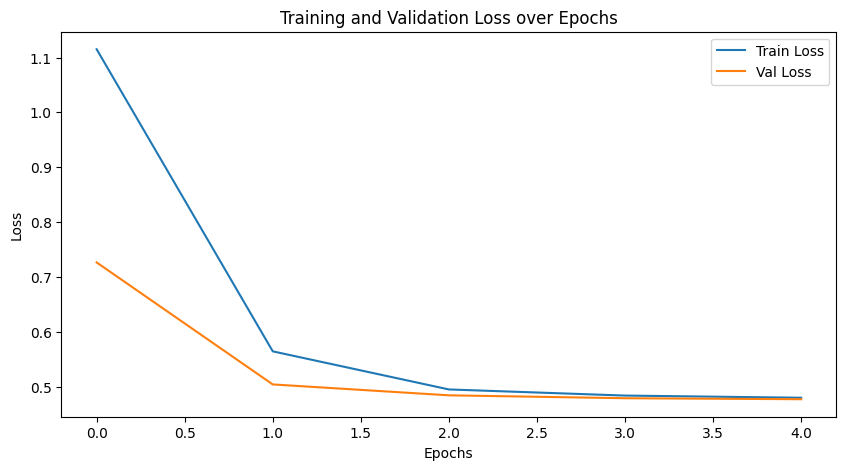

In [9]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)


In [10]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            
            if isinstance(outputs, list):
                outputs = outputs[-1]  # Take the last output if using deep supervision
            
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) * labels.size(1) * labels.size(2)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

test_loss, test_accuracy = evaluate_model(trained_model, test_loader, final_criterion)

# Save the trained model
torch.save(trained_model.state_dict(), 'final_unetplusplus_model.pth')
print("Model saved as 'final_unetplusplus_model.pth'")

Testing: 100%|██████████| 267/267 [09:31<00:00,  2.14s/it]

Test Loss: 0.4772
Test Accuracy: 100.00%
Model saved as 'final_unetplusplus_model.pth'


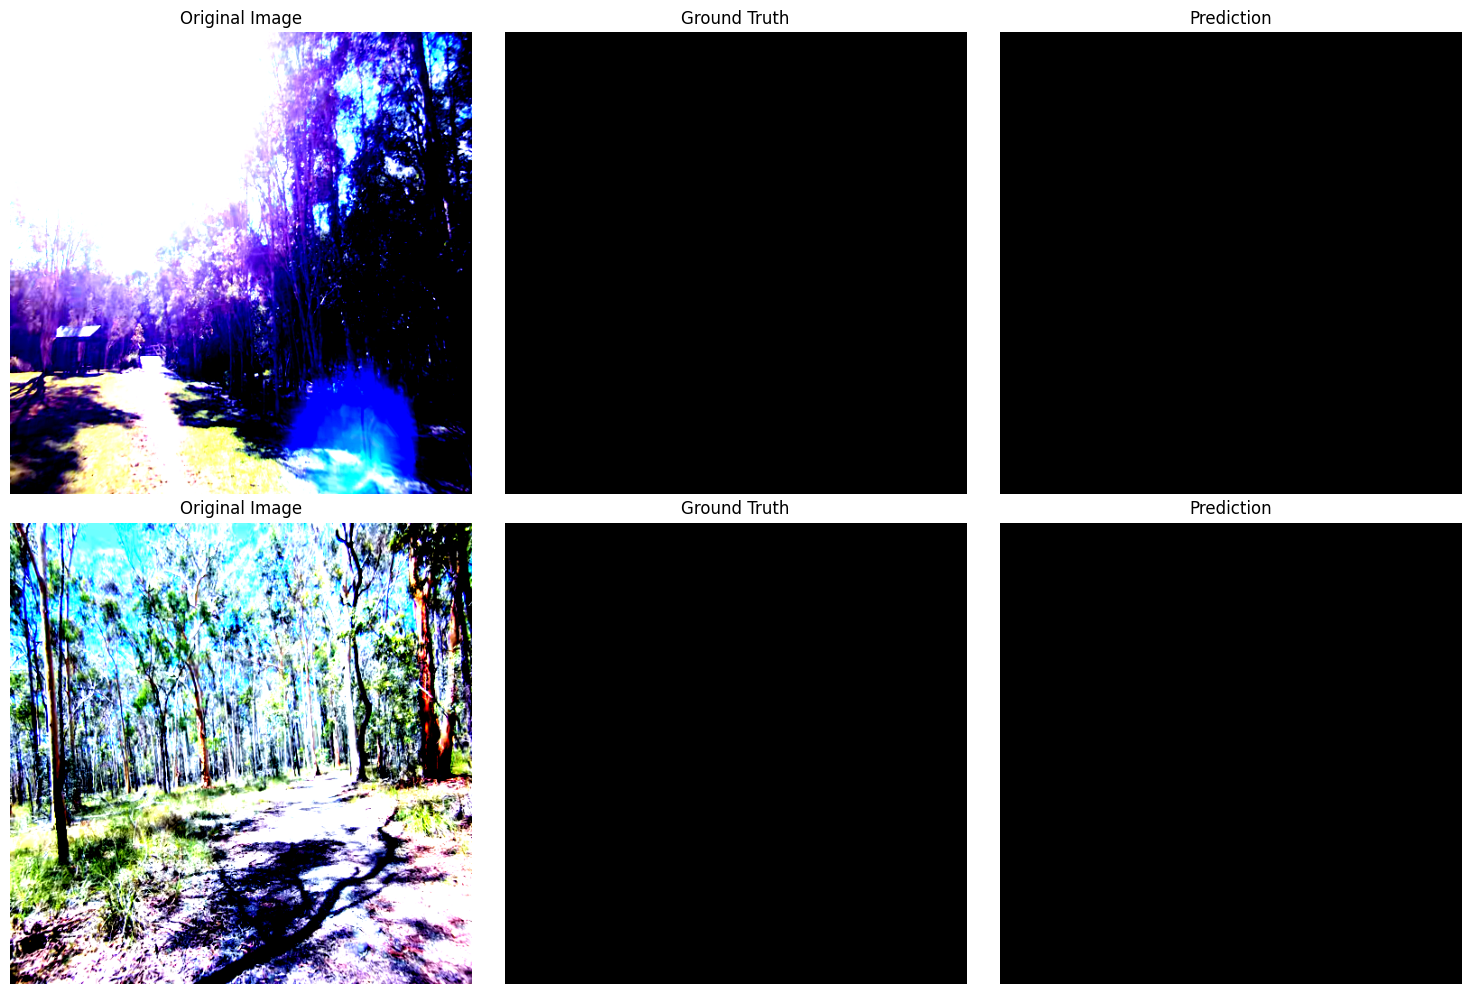

Training and evaluation complete.


In [11]:
def visualize_prediction(model, test_loader, num_classes):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.cuda(), labels.cuda()

    with torch.no_grad():
        outputs = model(images)
        if isinstance(outputs, list):
            outputs = outputs[-1]
        _, preds = torch.max(outputs, 1)

    # Convert tensors to numpy arrays
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot the results
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    for i in range(2):
        # Original image
        axs[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')
        
        # Ground truth
        axs[i, 1].imshow(labels[i], cmap='nipy_spectral', vmin=0, vmax=num_classes-1)
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')
        
        # Prediction
        axs[i, 2].imshow(preds[i], cmap='nipy_spectral', vmin=0, vmax=num_classes-1)
        axs[i, 2].set_title('Prediction')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_prediction(trained_model, test_loader, NUM_CLASSES)

print("Training and evaluation complete.")